In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.12.0'

In [3]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-e522cwba
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-e522cwba
  Resolved https://github.com/tensorflow/docs to commit af1c1d2ceac5d015c9f6ee5ed5b30eb2d2f5f6c1
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182618 sha256=2f47d8fc72ffb9f593bfa7269dd5d43323a2d0a2cf28b6a61df4b13af68c060e
  Stored in directory: /tmp/pip-ephem-wheel-cache-6fs0vlzz/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs


In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

In [5]:
(train_images, train_labels),(_,_)=\
tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [6]:
train_images.shape,train_images[0].shape

((60000, 28, 28), (28, 28))

In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [8]:
train_images[0].shape

(28, 28, 1)

In [9]:
train_images[0][0].shape

(28, 1)

In [10]:
train_images[0][0][:4]

array([[-1.],
       [-1.],
       [-1.],
       [-1.]], dtype=float32)

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [12]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).\
shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [14]:
#Generator <Big to Small)
#256 
#128
#64
#1

<h3>Generator

In [15]:
#input is noise
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

#output is fake image

In [16]:
model = make_generator_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [7]:
28*5

140

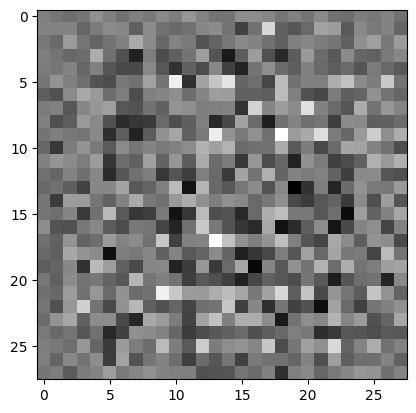

In [17]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)


plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<h3> Discriminator

In [18]:
#Small to big
#64
#128
#1

In [21]:
#input is fake image
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
#ouput is decision if fake image is real or not

In [22]:
model= make_discriminator_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [23]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00090739]], shape=(1, 1), dtype=float32)


#ARCHITECTURE
1) Generate random image <br>
2) send noise to generator to produce FAKE IMAGE<br>
3) Fake image is send to discriminator<br>
4) discriminator tells is this image is fake or not 1 or 0<br>

In [24]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
decision = discriminator(generated_image)

In [25]:
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00380671]], shape=(1, 1), dtype=float32)


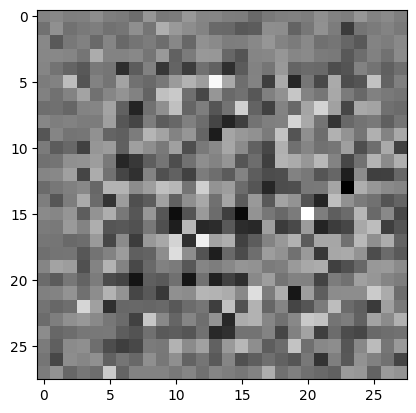

In [26]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

<h4> Cross Entrophy example

In [27]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
#eg
tf.zeros([3, 4]) * tf.random.normal([3, 4])

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0., -0., -0.,  0.],
       [ 0.,  0., -0., -0.],
       [-0.,  0.,  0.,  0.]], dtype=float32)>

In [29]:
cross_entropy(tf.zeros([3, 4]) , tf.random.normal([3, 4])).numpy()

0.55091625

<h4> loss example

In [30]:
#we send fake images to discriminator
#discriminator needs to tell if its real of fake
# CRoss entrophy is multiplication of predictions * real
#eg : 0.3 *1 = 0.3  real loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [31]:
#eg .6 * 1 = .6
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [32]:
#optimizers = gradient descent

In [33]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [34]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [35]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

In [36]:
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[ 0.2501206 ,  0.6135382 ,  0.2761146 , ...,  0.24693333,
         0.94799334,  1.05188   ],
       [ 0.35486254,  0.60319054, -0.21571922, ..., -1.4084328 ,
        -0.05471378, -1.2566972 ],
       [ 1.3664867 ,  1.1249298 ,  0.9431718 , ..., -0.10835669,
        -0.8330728 , -0.9678717 ],
       ...,
       [ 1.8996837 , -0.9238529 , -1.209201  , ...,  0.32818577,
        -0.8225632 ,  0.14180885],
       [ 0.8247648 , -0.30214617, -0.22762965, ..., -1.1444484 ,
         0.76719767,  1.8152276 ],
       [ 0.05883035, -0.28367636, -0.02365059, ..., -1.4143146 ,
         0.18037003,  0.02330049]], dtype=float32)>

In [37]:
#PSEUDO CODE
#setting up the training steps
#gradient descent
#generate FAKE images , Training = True

#1 get decision real_images  
#= discriminator( SEND REAL IMAGES , training = true)
#2 get fake images  =  Discriminator ( fake images , training = true)

#get loss generator
#get loss discriminator

#get gradients of discriminator
#get gradients of discriminator
#apply optimizer for discriminator learning
#apply optimizer for gradient learning

In [38]:
@tf.function
def train_step(images):
    #gets random noise in batch size
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #GENERATOR
        generated_images = generator(noise, training=True)
        
        #discrimainator train on real images
        real_output = discriminator(images, training= True)
        
        #discrimainator train on fake images
        fake_output = discriminator(generated_images, training= True)
        
        #Get LOSSES
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #get gradients
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        #optimizers
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [39]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,seed)

In [40]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

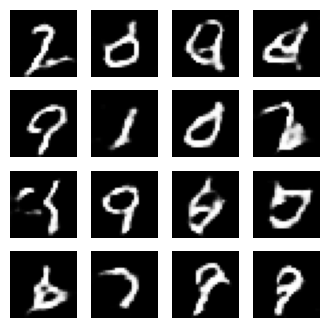

In [41]:
train(train_dataset, EPOCHS)

In [42]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [43]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

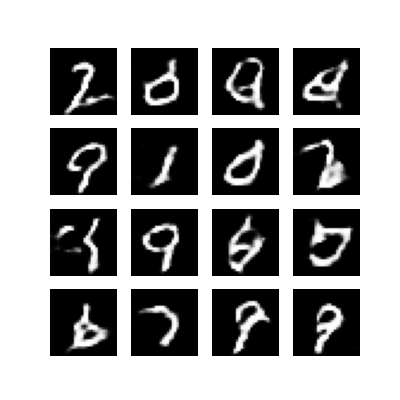

In [44]:
display_image(EPOCHS)

In [45]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

<ipython-input-45-19d8e987e05b>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-45-19d8e987e05b>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



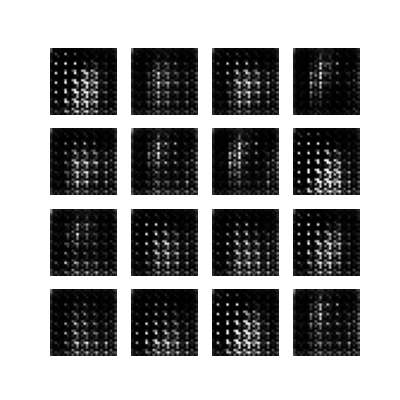

In [46]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

# New Section